In [45]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectFromModel

from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

from sklearn.metrics import balanced_accuracy_score

# Artificial dataset

## Load datasets

##### artificial_train_x

In [2]:
artificial_train_x = pd.read_csv("datasets/artificial_train.data", sep = " ", header=None).iloc[:, 0:500]
artificial_train_x.head()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,485,477,537,479,452,471,491,476,475,473,...,477,481,477,485,511,485,481,479,475,496
1,483,458,460,487,587,475,526,479,485,469,...,463,478,487,338,513,486,483,492,510,517
2,487,542,499,468,448,471,442,478,480,477,...,487,481,492,650,506,501,480,489,499,498
3,480,491,510,485,495,472,417,474,502,476,...,491,480,474,572,454,469,475,482,494,461
4,484,502,528,489,466,481,402,478,487,468,...,488,479,452,435,486,508,481,504,495,511


##### artificial_train_y

In [3]:
artificial_train_y = pd.read_csv("datasets/artificial_train.labels", sep = " ", header=None).iloc[:, 0]
artificial_train_y[artificial_train_y == -1] = 0
artificial_train_y.head()

0    0
1    0
2    0
3    1
4    1
Name: 0, dtype: int64

##### artificial_valid_x

In [4]:
artificial_test_x = pd.read_csv("datasets/artificial_valid.data", sep = " ", header=None).iloc[:, 0:500]
artificial_test_x.head()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,483,454,513,495,523,469,453,477,506,479,...,455,480,543,259,413,520,485,498,523,510
1,485,508,493,487,478,472,504,476,479,475,...,486,480,535,534,514,452,484,495,548,477
2,483,521,507,475,493,486,421,475,496,483,...,491,476,498,495,508,528,486,465,508,503
3,474,504,576,480,553,483,524,478,483,483,...,521,475,470,463,509,525,479,467,552,517
4,495,474,523,479,495,488,485,476,497,478,...,510,471,522,343,509,520,475,493,506,491


## Train valid split

In [5]:
X_train, X_valid, y_train, y_valid = train_test_split(
    artificial_train_x, 
    artificial_train_y,
    test_size=0.2,
    shuffle=True,
)

## Feature selection - artificial

### Method 1 - forward feature selection

In [6]:
# all methods
def variance_threshold(X_train, t):
    print("variance_threshold")

    sel = VarianceThreshold(threshold=t)
    sel.fit_transform(X_train)
    
    return X_train.loc[:, sel.get_support()]


def mean_absolute_deviance(X_train, t):
    print("mean_absolute_deviance")

    mad = np.sum(np.abs(X_train - np.mean(X_train, axis=0)), axis=0) / X_train.shape[0]
    return X_train.loc[:, mad > t] 


def high_correlation(X_train, t):
    print("high_correlation")
    
    corr_matrix = X_train.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > t)]
    X_train.drop(to_drop, axis=1, inplace=True)
    return X_train


def information_gain(X_train, y_train, t):
    print("information_gain")

    importance = mutual_info_classif(X_train, y_train)
    return X_train.loc[:, importance > np.quantile(importance, t)]


def fisher_score(X_train, y_train, t):
    print("fisher_score")
    chi2_selector = SelectKBest(chi2, k=t)
    chi2_selector.fit(X_train, y_train)

    return X_train.loc[:, chi2_selector.get_support()]


In [7]:
# method 1
def forward_feature_selection(X_train, y_train, t):
    print("forward_features_selection")
    
    model = XGBClassifier()
    sfs = SequentialFeatureSelector(model, n_features_to_select=t)
    sfs.fit(X_train, y_train)
    return X_train.loc[:, sfs.get_support()]

# method 2
def recursive_feature_eliminator(X_train, y_train, t):
    print("recursive_feature_eliminator")

    model = XGBClassifier()
    rfe = RFE(estimator=model, n_features_to_select=t, step=1)
    rfe.fit(X_train, y_train)
    return X_train.loc[:, rfe.get_support()]

# method 3
def select_from_model(X_train, y_train, t):
    print("select_from_model")

    sfm = SelectFromModel(XGBClassifier(n_estimators=100), max_features=t)
    sfm.fit(X_train, y_train)
    return X_train.loc[:, sfm.get_support()]

# method 4
def logistic_regression_l1(X_train, y_train, t):
    print("logistic_regression_l1")

    sfm = SelectFromModel(LogisticRegression(C=1, penalty='l1', solver='liblinear', max_iter=1000))
    sfm.fit(X_train, y_train)
    return X_train.iloc[:, sfm.get_support()]

In [8]:
def feature_selection_method1(settings, X_train, y_train, X_valid, y_valid):
    # Feature selection
    print(f"Features initial: {X_train.shape[1]}\n")

    ## Methods to remove unnecessary features
    X_train_t = variance_threshold(X_train, settings["variance_threshold"])
    print(f"Features left: {X_train_t.shape[1]}\n")

    X_train_t = mean_absolute_deviance(X_train_t, settings["mean_absolute_deviance"])
    print(f"Features left: {X_train_t.shape[1]}\n")

    X_train_t = high_correlation(X_train_t, settings["high_correlation"])
    print(f"Features left: {X_train_t.shape[1]}\n")

    ## Methods to take important features
    X_train_t = information_gain(X_train_t, y_train, settings["information_gain"])
    print(f"Features left: {X_train_t.shape[1]}\n")

    X_train_t = fisher_score(X_train_t, y_train, settings["fisher_score"])
    print(f"Features left: {X_train_t.shape[1]}\n")

    X_train_t = forward_feature_selection(X_train_t, y_train, settings["forward_feature_selection"])
    print(f"Features left: {X_train_t.shape[1]}\n")

    X_valid_t = X_valid.loc[:, X_train_t.columns]

    # Evaluation
    model = XGBClassifier()
    model.fit(X_train_t, y_train)

    y_train_pred = model.predict(X_train_t)
    y_valid_pred = model.predict(X_valid_t)

    print(f"Accuracy train: {np.round(balanced_accuracy_score(y_train, y_train_pred), 4)}")
    print(f"Accuracy valid: {np.round(balanced_accuracy_score(y_valid, y_valid_pred), 4)}")
    
    return X_train_t, X_valid_t


# smoke test
settings = {
    "variance_threshold": 0.1,
    "mean_absolute_deviance": 2,
    "high_correlation": 0.8,
    "information_gain": 0.7,
    "fisher_score": 5,
    "forward_feature_selection": 3,
}
X_train_t, X_test_t = feature_selection_method1(
    settings, 
    X_train, 
    y_train, 
    X_valid,
    y_valid,
)

Features initial: 500

variance_threshold
Features left: 500

mean_absolute_deviance
Features left: 477

high_correlation
Features left: 467

information_gain
Features left: 140

fisher_score
Features left: 5

forward_features_selection
Features left: 3

Accuracy train: 0.9806
Accuracy valid: 0.7199


In [ ]:
ffss = list(range(1, 21, 1))
iters = 3

j = 0
for ffs in ffss:
    for i in range(iters):
        settings = {
            "variance_threshold": 0.1,
            "mean_absolute_deviance": 2,
            "high_correlation": 0.8,
            "information_gain": 0.7,
            "fisher_score": 30,
            "forward_feature_selection": ffs,
        }

        X_train_t, X_valid_t = feature_selection_method1(
            settings, 
            X_train, 
            y_train, 
            X_valid,
            y_valid,
        )

        # accuracy on valid
        xgb = XGBClassifier()
        xgb.fit(X_train_t, y_train)


        ba_valid = np.round(balanced_accuracy_score(y_valid, xgb.predict(X_valid_t)), 2)

        pd.DataFrame(xgb.predict_proba(X_valid_t)).to_csv(f"output/artificial/method1/MACCHY_artificial_prediction_{ffs}_{i}.txt")

        np.savetxt(f"output/artificial/method1/MACCHY_artificial_features_{ffs}_{i}.txt", X_train_t.columns.values.astype(int), fmt="%i")

        j += 1

### Method 2 - recursive feature selection

In [52]:
def feature_selection_method2(settings, X_train, y_train, X_valid, y_valid):
    # Feature selection
    print(f"Features initial: {X_train.shape[1]}\n")

    ## Methods to remove unnecessary features
    X_train_t = variance_threshold(X_train, settings["variance_threshold"])
    print(f"Features left: {X_train_t.shape[1]}\n")

    X_train_t = mean_absolute_deviance(X_train_t, settings["mean_absolute_deviance"])
    print(f"Features left: {X_train_t.shape[1]}\n")

    X_train_t = high_correlation(X_train_t, settings["high_correlation"])
    print(f"Features left: {X_train_t.shape[1]}\n")

    ## Methods to take important features
    X_train_t = information_gain(X_train_t, y_train, settings["information_gain"])
    print(f"Features left: {X_train_t.shape[1]}\n")

    X_train_t = fisher_score(X_train_t, y_train, settings["fisher_score"])
    print(f"Features left: {X_train_t.shape[1]}\n")

    X_train_t = recursive_feature_eliminator(X_train_t, y_train, settings["recursive_feature_eliminator"])
    print(f"Features left: {X_train_t.shape[1]}\n")

    X_valid_t = X_valid.loc[:, X_train_t.columns]

    # Evaluation
    model = XGBClassifier()
    model.fit(X_train_t, y_train)

    y_train_pred = model.predict(X_train_t)
    y_valid_pred = model.predict(X_valid_t)

    print(f"Accuracy train: {np.round(balanced_accuracy_score(y_train, y_train_pred), 4)}")
    print(f"Accuracy valid: {np.round(balanced_accuracy_score(y_valid, y_valid_pred), 4)}")
    
    return X_train_t, X_valid_t


# smoke test
settings = {
    "variance_threshold": 0.1,
    "mean_absolute_deviance": 2,
    "high_correlation": 0.8,
    "information_gain": 0.7,
    "fisher_score": 5,
    "recursive_feature_eliminator": 3,
}
X_train_t, X_test_t = feature_selection_method2(
    settings, 
    X_train, 
    y_train, 
    X_valid,
    y_valid,
)

Features initial: 500

variance_threshold
Features left: 500

mean_absolute_deviance
Features left: 477

high_correlation
Features left: 467

information_gain
Features left: 140

fisher_score
Features left: 5

recursive_feature_eliminator
Features left: 3

Accuracy train: 0.9725
Accuracy valid: 0.7623


In [71]:
ffss = list(range(1, 21, 1))
iters = 3

j = 0
for ffs in ffss:
    for i in range(iters):
        settings = {
            "variance_threshold": 0.1,
            "mean_absolute_deviance": 2,
            "high_correlation": 0.8,
            "information_gain": 0.7,
            "fisher_score": 30,
            "recursive_feature_eliminator": ffs,
        }

        X_train_t, X_valid_t = feature_selection_method2(
            settings, 
            X_train, 
            y_train, 
            X_valid,
            y_valid,
        )

        # accuracy on valid
        xgb = XGBClassifier()
        xgb.fit(X_train_t, y_train)


        ba_valid = np.round(balanced_accuracy_score(y_valid, xgb.predict(X_valid_t)), 2)

        pd.DataFrame(xgb.predict_proba(X_valid_t)).to_csv(f"output/method2/MACCHY_artificial_prediction_{ffs}_{i}.txt")

        np.savetxt(f"output/method2/MACCHY_artificial_features_{ffs}_{i}.txt", X_train_t.columns.values.astype(int), fmt="%i")

        j += 1

Features initial: 500

variance_threshold
Features left: 500

mean_absolute_deviance
Features left: 477

high_correlation
Features left: 467

information_gain
Features left: 140

fisher_score
Features left: 30

recursive_feature_eliminator
Features left: 1

Accuracy train: 0.6812
Accuracy valid: 0.5654
Features initial: 500

variance_threshold
Features left: 500

mean_absolute_deviance
Features left: 477

high_correlation
Features left: 467

information_gain
Features left: 140

fisher_score
Features left: 30

recursive_feature_eliminator
Features left: 1

Accuracy train: 0.6812
Accuracy valid: 0.5654
Features initial: 500

variance_threshold
Features left: 500

mean_absolute_deviance
Features left: 477

high_correlation
Features left: 467

information_gain
Features left: 140

fisher_score
Features left: 30

recursive_feature_eliminator
Features left: 1

Accuracy train: 0.6812
Accuracy valid: 0.5654
Features initial: 500

variance_threshold
Features left: 500

mean_absolute_deviance
Fea

### Method 3 - select most important from xgboost

In [54]:
def feature_selection_method3(settings, X_train, y_train, X_valid, y_valid):
    # Feature selection
    print(f"Features initial: {X_train.shape[1]}\n")

    ## Methods to remove unnecessary features
    X_train_t = variance_threshold(X_train, settings["variance_threshold"])
    print(f"Features left: {X_train_t.shape[1]}\n")

    X_train_t = mean_absolute_deviance(X_train_t, settings["mean_absolute_deviance"])
    print(f"Features left: {X_train_t.shape[1]}\n")

    X_train_t = high_correlation(X_train_t, settings["high_correlation"])
    print(f"Features left: {X_train_t.shape[1]}\n")

    ## Methods to take important features
    X_train_t = information_gain(X_train_t, y_train, settings["information_gain"])
    print(f"Features left: {X_train_t.shape[1]}\n")

    X_train_t = fisher_score(X_train_t, y_train, settings["fisher_score"])
    print(f"Features left: {X_train_t.shape[1]}\n")

    X_train_t = select_from_model(X_train_t, y_train, settings["select_from_model"])
    print(f"Features left: {X_train_t.shape[1]}\n")

    X_valid_t = X_valid.loc[:, X_train_t.columns]

    # Evaluation
    model = XGBClassifier()
    model.fit(X_train_t, y_train)

    y_train_pred = model.predict(X_train_t)
    y_valid_pred = model.predict(X_valid_t)

    print(f"Accuracy train: {np.round(balanced_accuracy_score(y_train, y_train_pred), 4)}")
    print(f"Accuracy valid: {np.round(balanced_accuracy_score(y_valid, y_valid_pred), 4)}")
    
    return X_train_t, X_valid_t


# smoke test
settings = {
    "variance_threshold": 0.1,
    "mean_absolute_deviance": 2,
    "high_correlation": 0.8,
    "information_gain": 0.7,
    "fisher_score": 5,
    "select_from_model": 3,
}
X_train_t, X_test_t = feature_selection_method3(
    settings, 
    X_train, 
    y_train, 
    X_valid,
    y_valid,
)

Features initial: 500

variance_threshold
Features left: 500

mean_absolute_deviance
Features left: 477

high_correlation
Features left: 467

information_gain
Features left: 140

fisher_score
Features left: 5

select_from_model
Features left: 3

Accuracy train: 0.9669
Accuracy valid: 0.6849


In [72]:
ffss = list(range(1, 21, 1))
iters = 3

j = 0
for ffs in ffss:
    for i in range(iters):
        settings = {
            "variance_threshold": 0.1,
            "mean_absolute_deviance": 2,
            "high_correlation": 0.8,
            "information_gain": 0.7,
            "fisher_score": 30,
            "select_from_model": ffs,
        }

        X_train_t, X_valid_t = feature_selection_method3(
            settings, 
            X_train, 
            y_train, 
            X_valid,
            y_valid,
        )

        # accuracy on valid
        xgb = XGBClassifier()
        xgb.fit(X_train_t, y_train)


        ba_valid = np.round(balanced_accuracy_score(y_valid, xgb.predict(X_valid_t)), 2)

        pd.DataFrame(xgb.predict_proba(X_valid_t)).to_csv(f"output/artificial/method3/MACCHY_artificial_prediction_{ffs}_{i}.txt")

        np.savetxt(f"output/artificial/method3/MACCHY_artificial_features_{ffs}_{i}.txt", X_train_t.columns.values.astype(int), fmt="%i")

        j += 1

Features initial: 500

variance_threshold
Features left: 500

mean_absolute_deviance
Features left: 477

high_correlation
Features left: 467

information_gain
Features left: 140

fisher_score
Features left: 30

select_from_model
Features left: 1

Accuracy train: 0.6812
Accuracy valid: 0.5654
Features initial: 500

variance_threshold
Features left: 500

mean_absolute_deviance
Features left: 477

high_correlation
Features left: 467

information_gain
Features left: 140

fisher_score
Features left: 30

select_from_model
Features left: 1

Accuracy train: 0.6812
Accuracy valid: 0.5654
Features initial: 500

variance_threshold
Features left: 500

mean_absolute_deviance
Features left: 477

high_correlation
Features left: 467

information_gain
Features left: 140

fisher_score
Features left: 30

select_from_model
Features left: 1

Accuracy train: 0.6812
Accuracy valid: 0.5654
Features initial: 500

variance_threshold
Features left: 500

mean_absolute_deviance
Features left: 477

high_correlation

### Method 4 - logistic regression with L1 

In [56]:
def feature_selection_method4(settings, X_train, y_train, X_valid, y_valid):
    # Feature selection
    print(f"Features initial: {X_train.shape[1]}\n")

    ## Methods to remove unnecessary features
    X_train_t = variance_threshold(X_train, settings["variance_threshold"])
    print(f"Features left: {X_train_t.shape[1]}\n")

    X_train_t = mean_absolute_deviance(X_train_t, settings["mean_absolute_deviance"])
    print(f"Features left: {X_train_t.shape[1]}\n")

    X_train_t = high_correlation(X_train_t, settings["high_correlation"])
    print(f"Features left: {X_train_t.shape[1]}\n")

    ## Methods to take important features
    X_train_t = information_gain(X_train_t, y_train, settings["information_gain"])
    print(f"Features left: {X_train_t.shape[1]}\n")

    X_train_t = fisher_score(X_train_t, y_train, settings["fisher_score"])
    print(f"Features left: {X_train_t.shape[1]}\n")

    X_train_t = logistic_regression_l1(X_train_t, y_train, settings["logistic_regression_l1"])
    print(f"Features left: {X_train_t.shape[1]}\n")

    X_valid_t = X_valid.loc[:, X_train_t.columns]

    # Evaluation
    model = XGBClassifier()
    model.fit(X_train_t, y_train)

    y_train_pred = model.predict(X_train_t)
    y_valid_pred = model.predict(X_valid_t)

    print(f"Accuracy train: {np.round(balanced_accuracy_score(y_train, y_train_pred), 4)}")
    print(f"Accuracy valid: {np.round(balanced_accuracy_score(y_valid, y_valid_pred), 4)}")
    
    return X_train_t, X_valid_t


# smoke test
settings = {
    "variance_threshold": 0.1,
    "mean_absolute_deviance": 2,
    "high_correlation": 0.8,
    "information_gain": 0.7,
    "fisher_score": 5,
    "logistic_regression_l1": 3,
}
X_train_t, X_test_t = feature_selection_method4(
    settings, 
    X_train, 
    y_train, 
    X_valid,
    y_valid,
)

Features initial: 500

variance_threshold
Features left: 500

mean_absolute_deviance
Features left: 477

high_correlation
Features left: 467

information_gain
Features left: 140

fisher_score
Features left: 5

logistic_regression_l1
Features left: 5

Accuracy train: 0.9994
Accuracy valid: 0.7924


In [73]:
ffss = list(range(1, 21, 1))
iters = 3

j = 0
for ffs in ffss:
    for i in range(iters):
        settings = {
            "variance_threshold": 0.1,
            "mean_absolute_deviance": 2,
            "high_correlation": 0.8,
            "information_gain": 0.7,
            "fisher_score": 30,
            "logistic_regression_l1": ffs,
        }

        X_train_t, X_valid_t = feature_selection_method4(
            settings, 
            X_train, 
            y_train, 
            X_valid,
            y_valid,
        )

        # accuracy on valid
        xgb = XGBClassifier()
        xgb.fit(X_train_t, y_train)


        ba_valid = np.round(balanced_accuracy_score(y_valid, xgb.predict(X_valid_t)), 2)

        pd.DataFrame(xgb.predict_proba(X_valid_t)).to_csv(f"output/method4/MACCHY_artificial_prediction_{ffs}_{i}.txt")

        np.savetxt(f"output/artificial/method4/MACCHY_artificial_features_{ffs}_{i}.txt", X_train_t.columns.values.astype(int), fmt="%i")

        j += 1

Features initial: 500

variance_threshold
Features left: 500

mean_absolute_deviance
Features left: 477

high_correlation
Features left: 467

information_gain
Features left: 140

fisher_score
Features left: 30

logistic_regression_l1
Features left: 30

Accuracy train: 1.0
Accuracy valid: 0.7251
Features initial: 500

variance_threshold
Features left: 500

mean_absolute_deviance
Features left: 477

high_correlation
Features left: 467

information_gain
Features left: 140

fisher_score
Features left: 30

logistic_regression_l1
Features left: 30

Accuracy train: 1.0
Accuracy valid: 0.7296
Features initial: 500

variance_threshold
Features left: 500

mean_absolute_deviance
Features left: 477

high_correlation
Features left: 467

information_gain
Features left: 140

fisher_score
Features left: 30

logistic_regression_l1
Features left: 30

Accuracy train: 1.0
Accuracy valid: 0.6824
Features initial: 500

variance_threshold
Features left: 500

mean_absolute_deviance
Features left: 477

high_co

## Visualizations

### Method 1

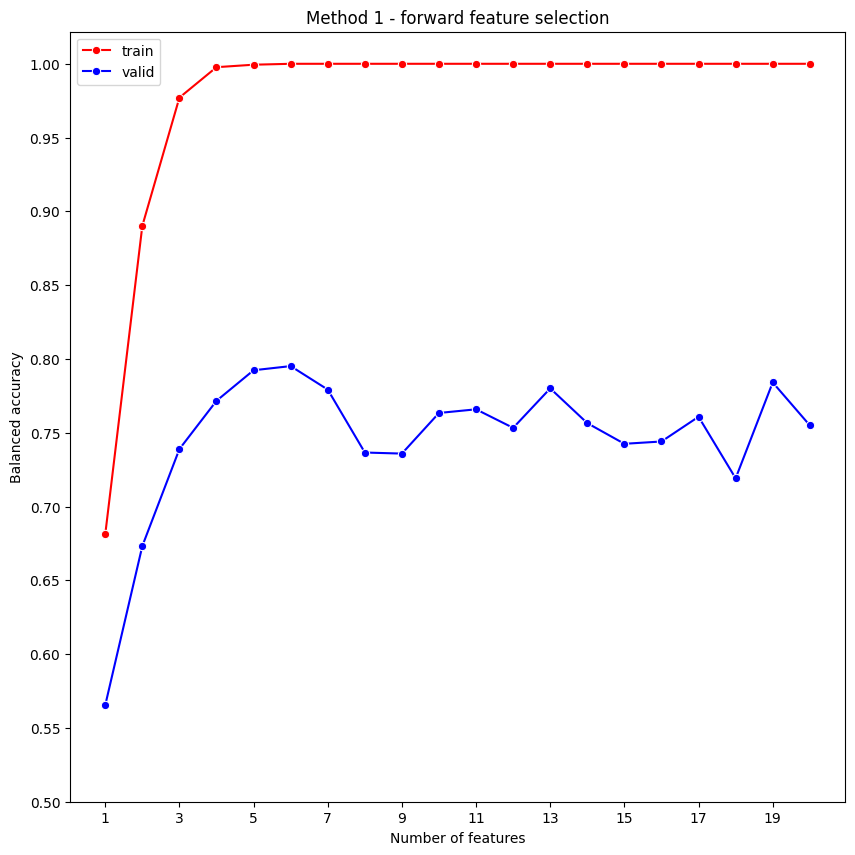

In [74]:
ffss = list(range(1, 21, 1))
iters = 3

b_accuracies_train = []
b_accuracies_valid = []

for j, ffs in enumerate(ffss):
    b_accuracies_train.append([])
    b_accuracies_valid.append([])
    for i in range(iters):
        with open(f"output/artificial/method1/MACCHY_artificial_features_{ffs}_{i}.txt") as f:
            columns = [int(line.rstrip()) for line in f]
            X_train_t = X_train.loc[:, columns]
            X_valid_t = X_valid.loc[:, columns]

            xgb = XGBClassifier()
            xgb.fit(X_train_t, y_train)

            b_accuracies_train[j].append(balanced_accuracy_score(y_train, xgb.predict(X_train_t)))
            b_accuracies_valid[j].append(balanced_accuracy_score(y_valid, xgb.predict(X_valid_t)))

plt.figure(figsize=(10, 10))
sns.lineplot(x=ffss, y=np.mean(b_accuracies_train, axis=1), marker="o", label="train", color="r")
sns.lineplot(x=ffss, y=np.mean(b_accuracies_valid, axis=1), marker="o", label="valid", color="b")

plt.title("Method 1 - forward feature selection")
plt.ylabel("Balanced accuracy")
plt.xlabel("Number of features")

plt.xticks(np.arange(min(ffss), max(ffss)+1, 2))
plt.yticks(np.arange(0.5, 1.025, 0.05))

plt.show()

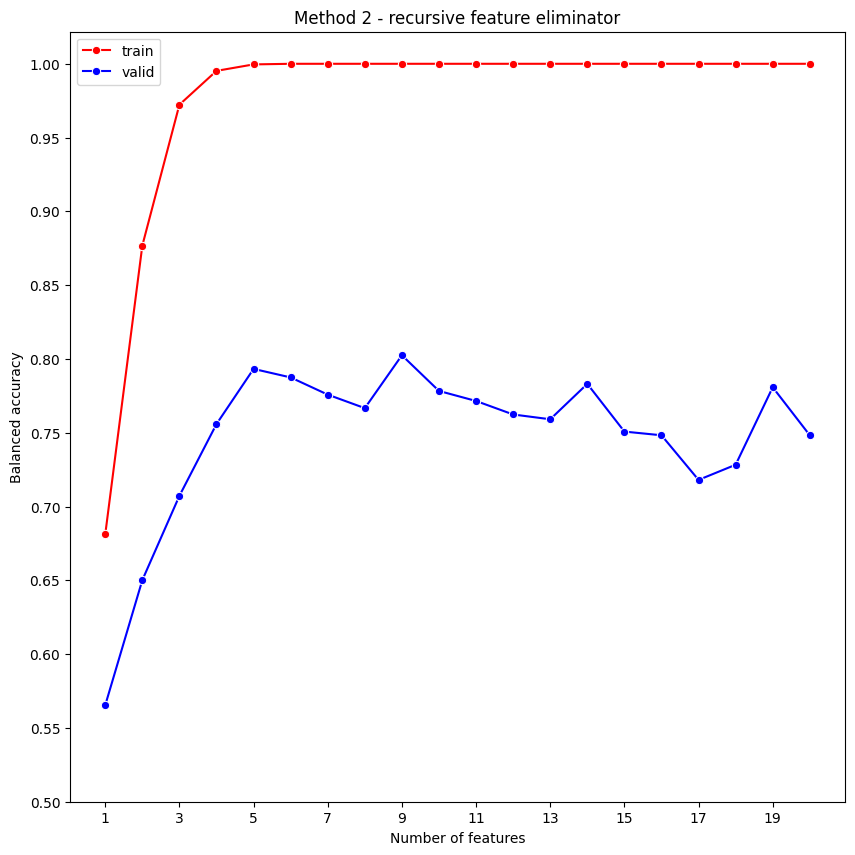

In [75]:
ffss = list(range(1, 21, 1))
iters = 3

b_accuracies_train = []
b_accuracies_valid = []

for j, ffs in enumerate(ffss):
    b_accuracies_train.append([])
    b_accuracies_valid.append([])
    for i in range(iters):
        with open(f"output/artificial/method2/MACCHY_artificial_features_{ffs}_{i}.txt") as f:
            columns = [int(line.rstrip()) for line in f]
            X_train_t = X_train.loc[:, columns]
            X_valid_t = X_valid.loc[:, columns]

            xgb = XGBClassifier()
            xgb.fit(X_train_t, y_train)

            b_accuracies_train[j].append(balanced_accuracy_score(y_train, xgb.predict(X_train_t)))
            b_accuracies_valid[j].append(balanced_accuracy_score(y_valid, xgb.predict(X_valid_t)))

plt.figure(figsize=(10, 10))
sns.lineplot(x=ffss, y=np.mean(b_accuracies_train, axis=1), marker="o", label="train", color="r")
sns.lineplot(x=ffss, y=np.mean(b_accuracies_valid, axis=1), marker="o", label="valid", color="b")

plt.title("Method 2 - recursive feature eliminator")
plt.ylabel("Balanced accuracy")
plt.xlabel("Number of features")

plt.xticks(np.arange(min(ffss), max(ffss)+1, 2))
plt.yticks(np.arange(0.5, 1.025, 0.05))

plt.show()

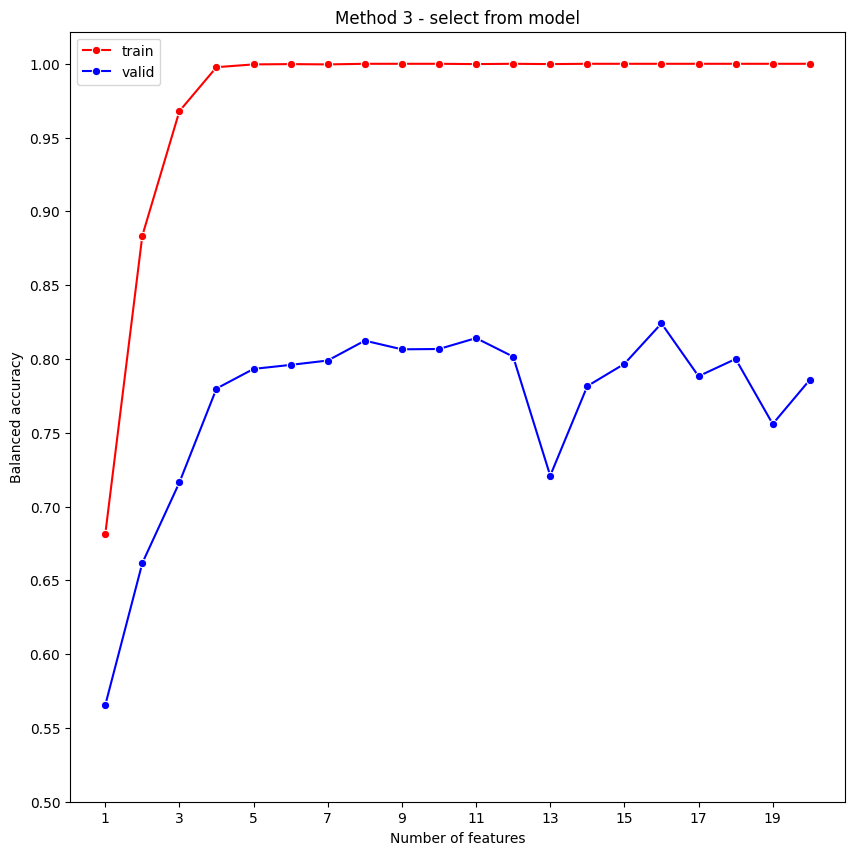

In [76]:
ffss = list(range(1, 21, 1))
iters = 3

b_accuracies_train = []
b_accuracies_valid = []

for j, ffs in enumerate(ffss):
    b_accuracies_train.append([])
    b_accuracies_valid.append([])
    for i in range(iters):
        with open(f"output/artificial/method3/MACCHY_artificial_features_{ffs}_{i}.txt") as f:
            columns = [int(line.rstrip()) for line in f]
            X_train_t = X_train.loc[:, columns]
            X_valid_t = X_valid.loc[:, columns]

            xgb = XGBClassifier()
            xgb.fit(X_train_t, y_train)

            b_accuracies_train[j].append(balanced_accuracy_score(y_train, xgb.predict(X_train_t)))
            b_accuracies_valid[j].append(balanced_accuracy_score(y_valid, xgb.predict(X_valid_t)))

plt.figure(figsize=(10, 10))
sns.lineplot(x=ffss, y=np.mean(b_accuracies_train, axis=1), marker="o", label="train", color="r")
sns.lineplot(x=ffss, y=np.mean(b_accuracies_valid, axis=1), marker="o", label="valid", color="b")

plt.title("Method 3 - select from model")
plt.ylabel("Balanced accuracy")
plt.xlabel("Number of features")

plt.xticks(np.arange(min(ffss), max(ffss)+1, 2))
plt.yticks(np.arange(0.5, 1.025, 0.05))

plt.show()

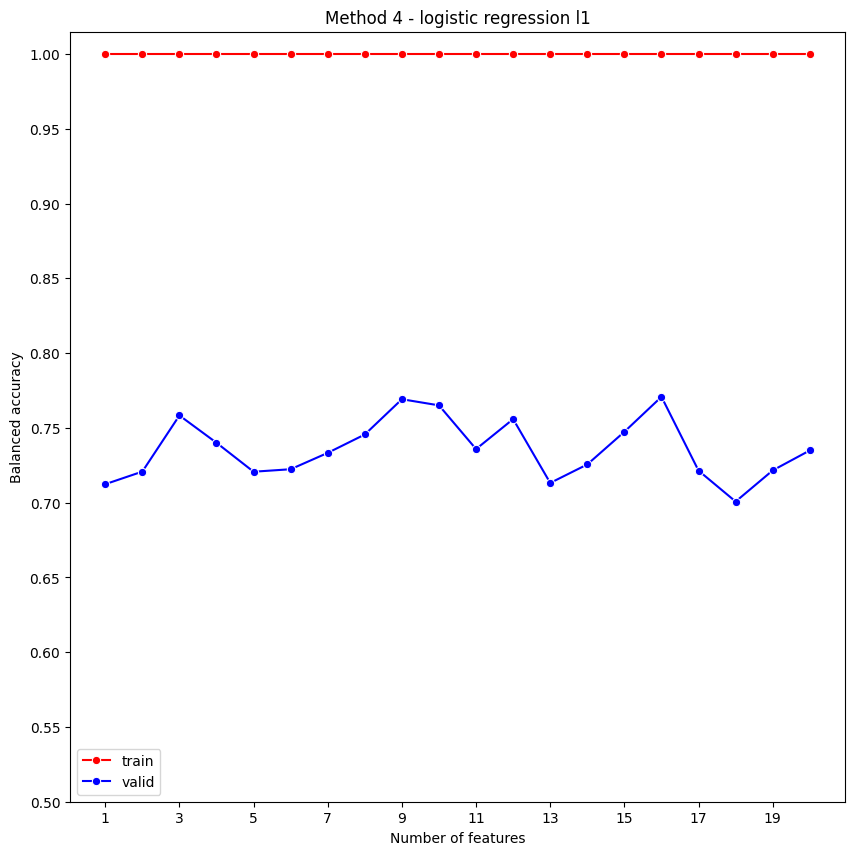

In [78]:
ffss = list(range(1, 21, 1))
iters = 3

b_accuracies_train = []
b_accuracies_valid = []

for j, ffs in enumerate(ffss):
    b_accuracies_train.append([])
    b_accuracies_valid.append([])
    for i in range(iters):
        with open(f"output/artificial/method4/MACCHY_artificial_features_{ffs}_{i}.txt") as f:
            columns = [int(line.rstrip()) for line in f]
            X_train_t = X_train.loc[:, columns]
            X_valid_t = X_valid.loc[:, columns]

            xgb = XGBClassifier()
            xgb.fit(X_train_t, y_train)

            b_accuracies_train[j].append(balanced_accuracy_score(y_train, xgb.predict(X_train_t)))
            b_accuracies_valid[j].append(balanced_accuracy_score(y_valid, xgb.predict(X_valid_t)))

plt.figure(figsize=(10, 10))
sns.lineplot(x=ffss, y=np.mean(b_accuracies_train, axis=1), marker="o", label="train", color="r")
sns.lineplot(x=ffss, y=np.mean(b_accuracies_valid, axis=1), marker="o", label="valid", color="b")

plt.title("Method 4 - logistic regression l1")
plt.ylabel("Balanced accuracy")
plt.xlabel("Number of features")

plt.xticks(np.arange(min(ffss), max(ffss)+1, 2))
plt.yticks(np.arange(0.5, 1.025, 0.05))

plt.show()

## Select best model

In [127]:
ffss = list(range(1, 21, 1))
iters = 3

b_accuracies_train = []
b_accuracies_test = []
methods = [f"{el}{i+1}" for i, el in enumerate(["method"] * 4)]

for method in methods:
    for j, ffs in enumerate(ffss):
        b_accuracies_train.append([])
        b_accuracies_test.append([])
        for i in range(iters):
            with open(f"output/artificial/{method}/MACCHY_artificial_features_{ffs}_{i}.txt") as f:
                columns = [int(line.rstrip()) for line in f]
                X_train_t = X_train.loc[:, columns]
                X_valid_t = X_valid.loc[:, columns]

                xgb = XGBClassifier()
                xgb.fit(X_train_t, y_train)
                if (b_acc := balanced_accuracy_score(y_valid, xgb.predict(X_valid_t))) >= 0.85:
                    print(f"METHOD: {method}, FEATURES: {ffs}, ITER: {i}, B_ACC: {b_acc}, COLUMNS: {X_train_t.columns.values}")


METHOD: method3, FEATURES: 16, ITER: 1, B_ACC: 0.8625112511251125, COLUMNS: [ 48  64 105 153 241 442]


In [129]:
X_train_final = artificial_train_x.loc[:, [48, 64, 105, 153, 241, 442]]
X_test_final = artificial_test_x.loc[:, [48, 64, 105, 153, 241, 442]]

xgb.fit(X_train_final, artificial_train_y)

pd.DataFrame(xgb.predict_proba(X_test_final)).to_csv("output/artificial/final/MACCHY_artificial_prediction.txt", index=None)
np.savetxt("output/artificial/final/MACCHY_artificial_features.txt", X_test_final.columns.values.astype(int), fmt="%i")